# 미니 프로젝트 : Segmentation map 으로 도로 이미지 만들기
이전 Pix2Pix 논문에서 제시한 결과 중에 아래와 같은 실험 결과가 있었다. 도로의 레이블 정보를 활용해 이미지를 생성해낸 결과이다.


![image](https://user-images.githubusercontent.com/84179578/134294933-61421248-b883-4185-8178-f569d9bd246d.png)

이번 프로젝트는 위와 같은 데이터셋을 이용해 Pix2Pix를 학습시켜보는 것이다.

## 1 . 데이터 준비

In [1]:
import os

data_path = 'EP19_data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


학습용 데이터셋에서 임의로 6장을 선택하여 시각화한다.

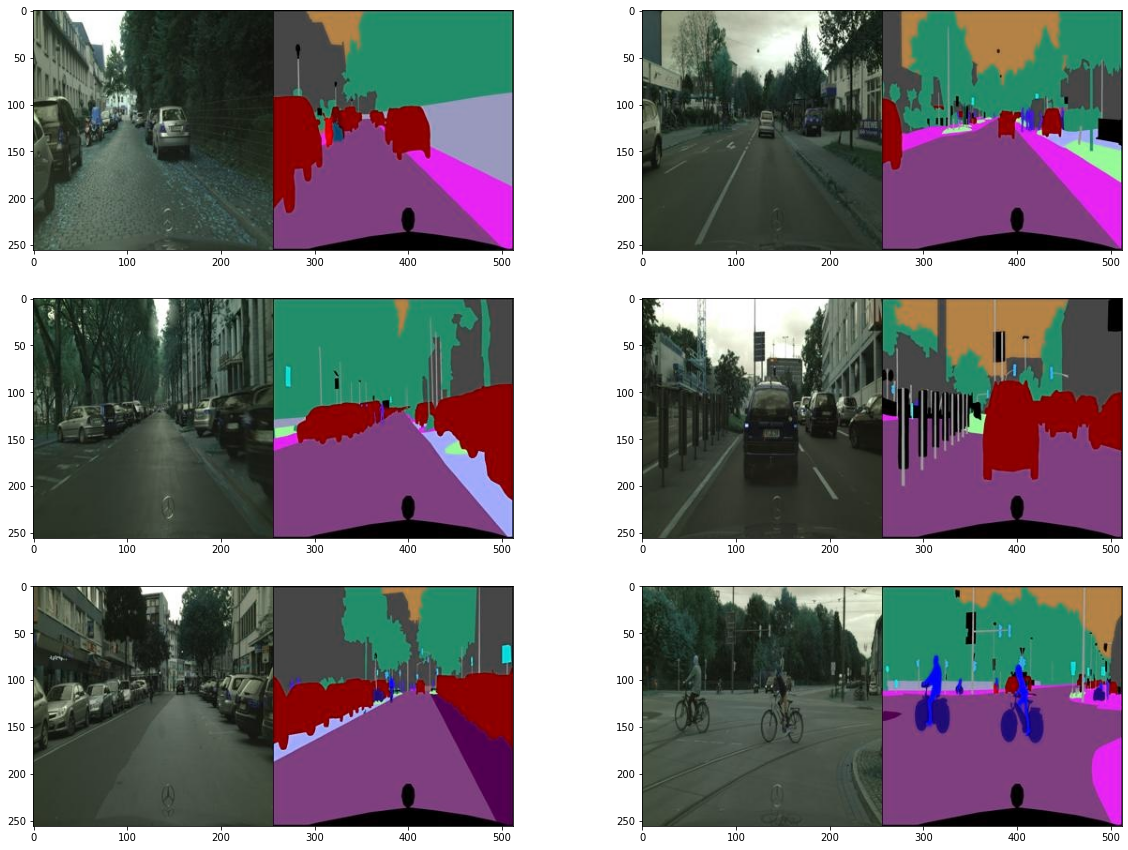

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [3]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


이미지의 크기는 (256, 512, 3)으로 확인된다. 모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용한다.

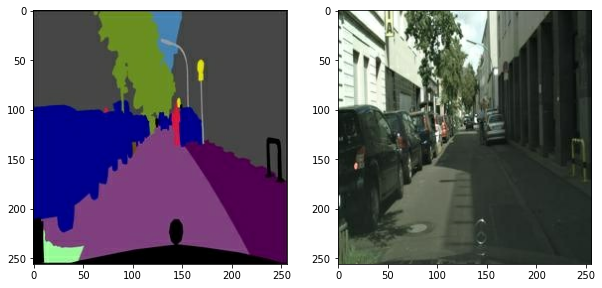

In [4]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    seg_img = img[:, w:, :] 
    seg_img = tf.cast(seg_img, tf.float32)
    real_img = img[:, :w, :] 
    real_img = tf.cast(real_img, tf.float32)
    return normalize(seg_img), normalize(real_img)

f = data_path + os.listdir(data_path)[1]
seg_img, real_img = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(seg_img))
plt.subplot(1,2,2); plt.imshow(denormalize(real_img))

## 2. 데이터 전처리

학습 데이터의 다양성을 높이기 위해 아래와 같은 여러 augmentation 방법을 적용한다.
- 두 이미지를 채널 축으로 연결 (`tf.concat`)
- 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼 적용(`tf.pad`)
- (256,256,6) 크기를 가진 이미지를 임의로 잘라냄(`tf.image.random_crop`)
- 각각 50% 확률로 가로 및 세로로 뒤집음 (`tf.image.random_flip_left_right`, `tf.image.random_flip_up_down`)
- 50% 확률로 90도 회전 (`tf.image.rot90`)

In [5]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(seg_img, real_img):
    stacked = tf.concat([seg_img, real_img], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]

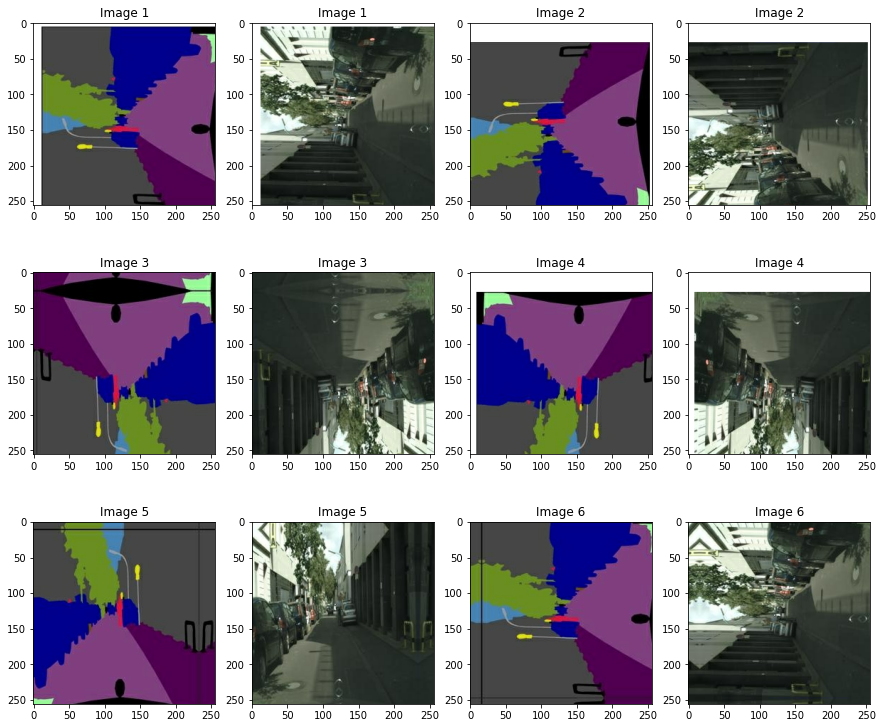

In [6]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_seg_img, augmented_real_img = apply_augmentation(seg_img, real_img)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_seg_img)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_real_img)); plt.title(f"Image {img_n}")
    img_n += 1

위 과정들을 학습 데이터에 적용하며, 잘 적용되었는지 하나의 이미지만 시각화하여 확인해보자

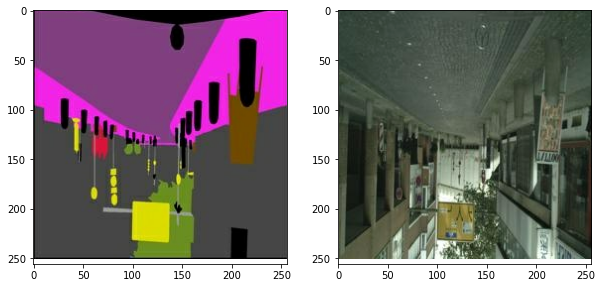

In [7]:
from tensorflow import data

def get_train(img_path):
    seg_img, real_img = load_img(img_path)
    seg_img, real_img = apply_augmentation(seg_img, real_img)
    return seg_img, real_img

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
seg_img, real_img = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(seg_img[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(real_img[0].astype(np.uint8))

## 2. Generator 구성
Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용한다.

In [8]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [9]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

완성된 U-Net 구조 Generator 내부의 각 출력이 적절한지 확인해보자.

In [10]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

## 3. Discriminator 구성

In [11]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x

In [12]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [13]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

## 4. 학습 및 테스트

먼저 학습에 필요한 손실함수부터 정의하겠다.  
레이블 정보만 있는 입력에 대해 여러 손실함수를 사용해 실제 이미지를 만들어 낸 결과는, 일반적인 GAN의 손실함수에 L1을 추가로 이용했을 때 가장 실제에 가까운 이미지를 생성해 냈다. 이번 실험에서도 두 가지 손실 함수를 모두 사용해보겠다.

In [14]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [15]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [16]:
@tf.function
def train_step(input_image, real_image):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        gen_output = generator(input_image, training=True)
        # Discriminator 예측
        fake_disc = discriminator(input_image, gen_output, training=True)
        real_disc = discriminator(input_image, real_image, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(gen_output, real_image, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [17]:
EPOCHS = 20 

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 반복마다 손실을 출력
        if (i+1) % 20 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[20]                     
Generator_loss:0.8625                     
L1_loss:0.2599                     
Discriminator_loss:1.5593

EPOCH[1] - STEP[40]                     
Generator_loss:0.9337                     
L1_loss:0.1936                     
Discriminator_loss:1.2567

EPOCH[1] - STEP[60]                     
Generator_loss:1.1230                     
L1_loss:0.2000                     
Discriminator_loss:1.3127

EPOCH[1] - STEP[80]                     
Generator_loss:1.2211                     
L1_loss:0.1873                     
Discriminator_loss:0.9608

EPOCH[1] - STEP[100]                     
Generator_loss:0.9793                     
L1_loss:0.2401                     
Discriminator_loss:0.9409

EPOCH[1] - STEP[120]                     
Generator_loss:1.4283                     
L1_loss:0.1911                     
Discriminator_loss:0.8859

EPOCH[1] - STEP[140]                     
Generator_loss:1.1990                     
L1_loss:0.1831                 

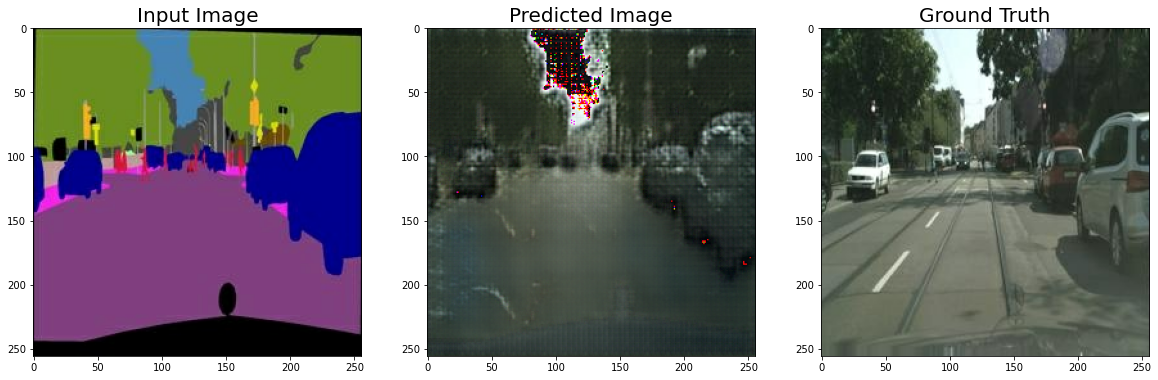

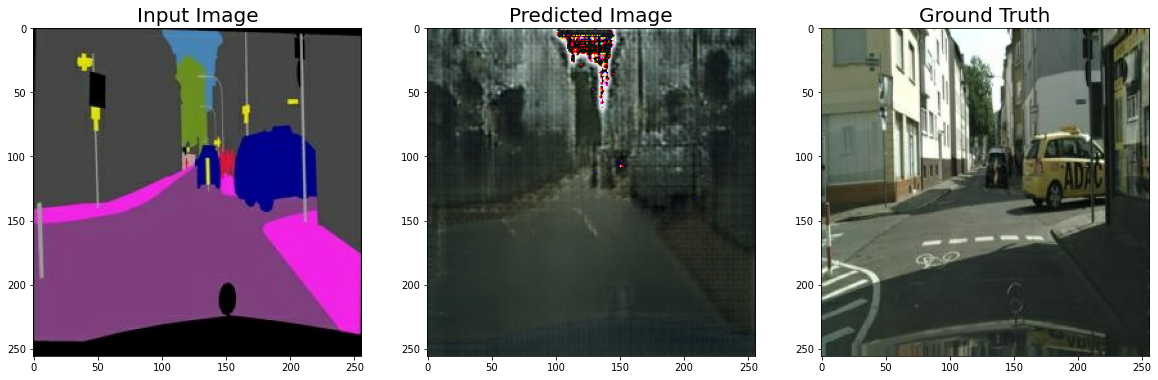

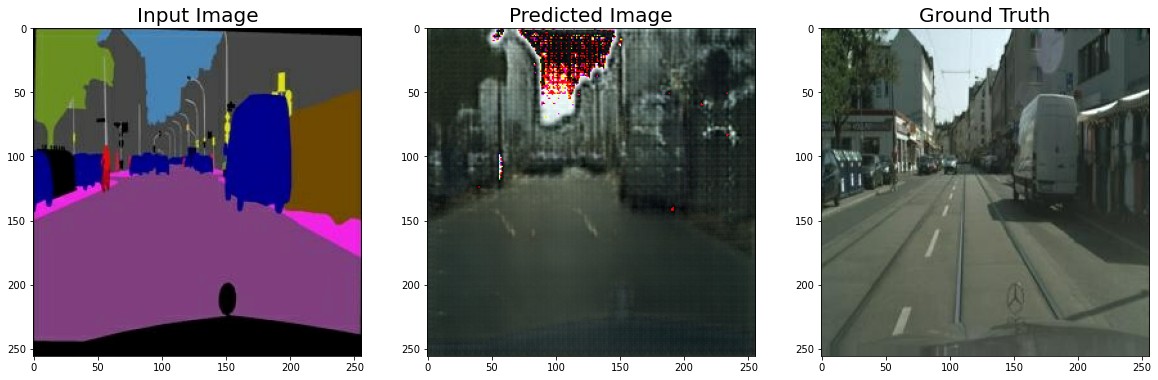

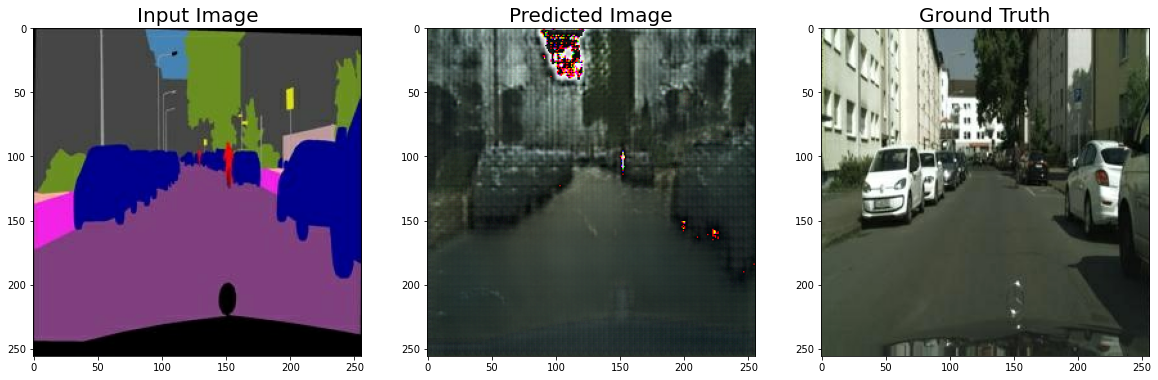

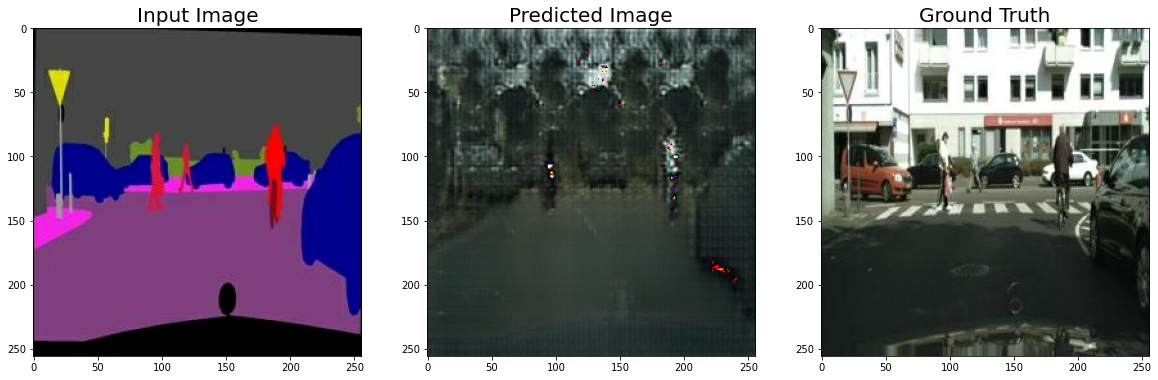

In [19]:
test_path = 'EP19_data/cityscapes/val/'

for i in range(5):
    f = test_path + os.listdir(test_path)[i]
    seg_img, real_img = load_img(f)

    pred = generator(tf.expand_dims(seg_img, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(seg_img)); plt.title('Input Image', fontsize=20)
    plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image', fontsize=20)
    plt.subplot(1,3,3); plt.imshow(denormalize(real_img)); plt.title('Ground Truth', fontsize=20)

`epochs = 20` 으로는 아직 만족할만한 결과물이 나오지 않는다. 더 나은 품질의 이미지 생성을 위해 100epochs 를 추가로 학습한다.

In [20]:
EPOCHS = 100 

for epoch in range(1, EPOCHS+1):
    for i, (seg_img, real_img) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(seg_img, real_img)
                
        # 반복마다 손실을 출력
        if (i+1) % 100 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[100]                     
Generator_loss:0.6220                     
L1_loss:0.2035                     
Discriminator_loss:0.8679

EPOCH[1] - STEP[200]                     
Generator_loss:2.5244                     
L1_loss:0.2203                     
Discriminator_loss:0.2989

EPOCH[2] - STEP[100]                     
Generator_loss:0.4605                     
L1_loss:0.1668                     
Discriminator_loss:1.1991

EPOCH[2] - STEP[200]                     
Generator_loss:0.7515                     
L1_loss:0.1977                     
Discriminator_loss:0.8223

EPOCH[3] - STEP[100]                     
Generator_loss:1.2805                     
L1_loss:0.1793                     
Discriminator_loss:0.8843

EPOCH[3] - STEP[200]                     
Generator_loss:0.8030                     
L1_loss:0.1731                     
Discriminator_loss:0.7418

EPOCH[4] - STEP[100]                     
Generator_loss:1.6325                     
L1_loss:0.1906             

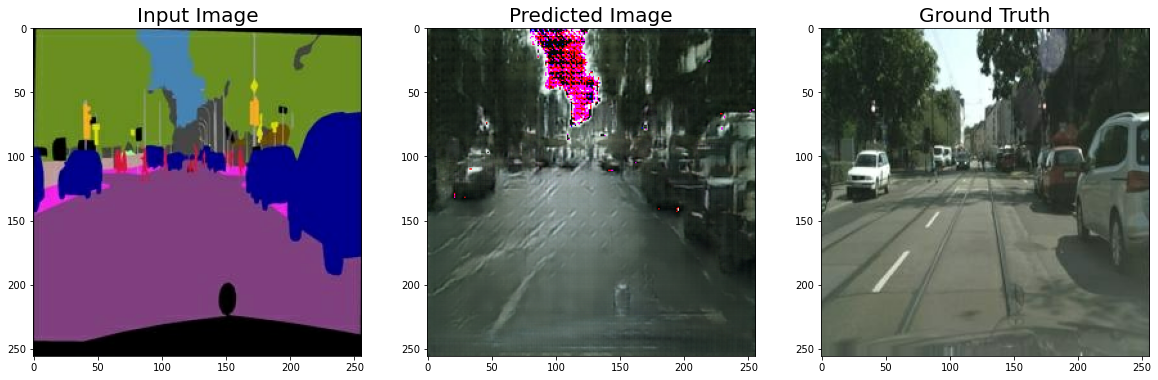

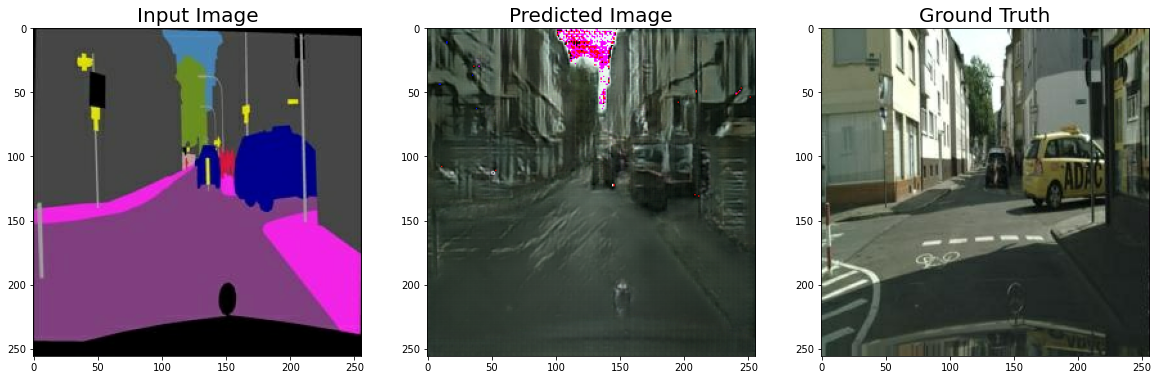

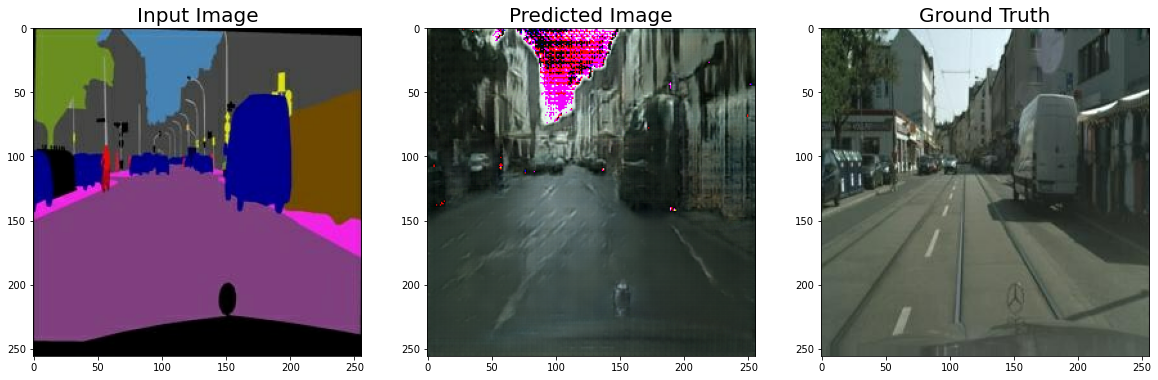

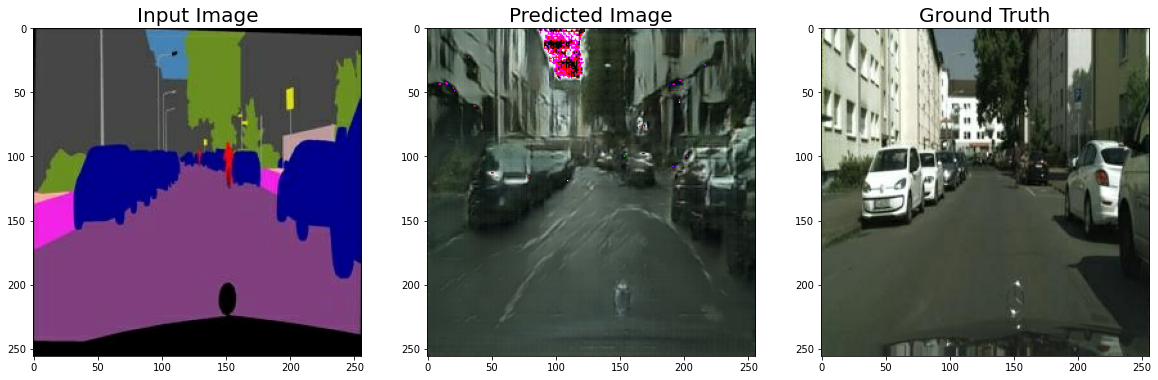

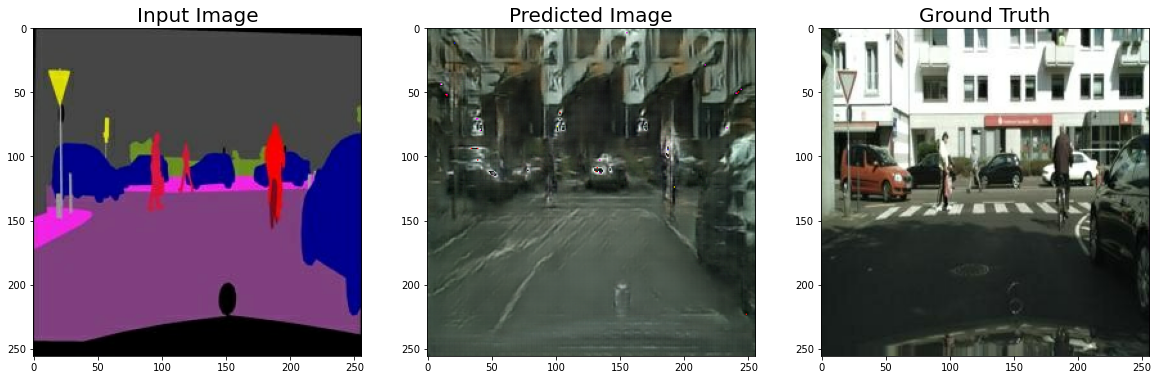

In [21]:
test_path = 'EP19_data/cityscapes/val/'

for i in range(5):
    f = test_path + os.listdir(test_path)[i]
    seg_img, real_img = load_img(f)

    pred = generator(tf.expand_dims(seg_img, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(seg_img)); plt.title('Input Image', fontsize=20)
    plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image', fontsize=20)
    plt.subplot(1,3,3); plt.imshow(denormalize(real_img)); plt.title('Ground Truth', fontsize=20)

확실히 `epochs=20` 으로 학습을 진행했을때 보다 결과물이 만족스럽게 나온것을 확인 할 수 있다.  

더 좋은 결과물을 위해서는 epochs 값을 더 높여서 학습하면 될 것으로 예상된다.